# Image classification using neural networks

Deep neural networks are the current best approach in artificial intelligence and machine learning systems. Machine learning is often called "deep learning" because the learning happens in deep neural networks, with many artificial neurons between the input and the output.

A neural network is based on an analogue of the brain, with _neurons_ (nerve cells) connected to each other in a _network_. Each neuron takes a bunch of inputs (whether from the inputs to the network or from other neurons), adds them up, and uses that to generate an output. Those outputs then feed into either other neurons or the output of the network as a whole. 

Each neuron has several parameters. Each input to the neuron is weighted, and it's these weighted inputs that are added. Each neuron also has a bias, that acts as a threshold value for whether it generates an output.

These neurons are typically organised in _layers_, with neurons in one layer feeding forward into the next. The diagram below shows a network of a few _dense_ layers, where each input to the layer feeds into each neuron.

![A sample neural network](./pic/sample_neural_network.png)

To do image classification with this type of neural network, each pixel in the image is one input. The value of each pixel feeds into each neuron in the first layer, and so on through the network. The final layer has one neuron per class the network knows about, and the values at these outputs is the probability that this image is an example of each of the classes. 

When it's first created, the network has random weights throughout, so generates random classifications for each input. This is generally not what we want. 

To train the network, we need a large collection of images, each with its _label_ of the true class for that image. During training, we feed in an image and compare the output generated by the network to the output we want (the image's label). We can then see how the network's actual output differs from the desired output, and find the _error_ (difference) between them. The actual output is a combination of the weights and inputs of the final layer of neurons. We can combine the error and the weights to work out how to adjust the weights going into the output layer, and how we should change the values on the neurons that feed into that layer. That gives us an error in the next-to-last layer of neurons; we can use that to adjust the weights feeding into that layer, and so on back to the input layer.

We then the next image from our training data and adjust the weights again. 

Once we've done all the images in the training set, we've completed one _epoch_ of training and the network is a bit better at classifying images. 

We then go through another epoch of training and the network hopefully improves a bit more. As we do more training, we get to the point of diminishing returns and we can stop. 

Enough talk. Let's build a neural network. 

# Loading some data

We need to train the neural network on some data, so we'll load some. We'll use the [standard CIFAR-10 set of small images](https://www.cs.toronto.edu/~kriz/cifar.html), in ten classes. 

First, we import the libraries we'll use.

In [2]:
# Load some toolkits we will need later
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, Sequential
from tensorflow.keras.layers import *

import tensorflow_datasets as tfds

We set some parameters then load the data.

In [3]:
ROWS = 32
COLS = 32
CHANNELS = 3
INPUT_SHAPE = (ROWS, COLS, CHANNELS)

BATCH_SIZE = 64

In [4]:
# Loading the data
(train_data, test_data), dataset_info = tfds.load('cifar10',
    data_dir='/datasets',
    split=['train', 'test'],
    with_info=True)
train_data, test_data, dataset_info

2024-10-11 13:04:18.207036: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(<_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 tfds.core.DatasetInfo(
     name='cifar10',
     full_name='cifar10/3.0.2',
     description="""
     The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
     """,
     homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
     data_dir='/datasets/cifar10/3.0.2',
     file_format=tfrecord,
     download_size=162.17 MiB,
     dataset_size=132.40 MiB,
     features=FeaturesDict({
         'id': Text(shape=(), dtype=string),
         'image': Image(shape=(32,

We'll reformat the dataset into the form we need for the network to use. We split the data into a _training_ set, that we use to train the network; a _validation_ set, that we use to keep an eye on training as it progresses, and a _test_ set for our final evaluation.

In [5]:
# Preparing the data

# define the list of class labels
class_names =  ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

class_num = len(class_names)

def ds_elem_transform(elem):
    return (tf.cast(elem['image'], tf.float32) / 255, # convert pixel values to range 0-1
           tf.one_hot(elem['label'], 10) # one-hot encoding for labels, 10 choices
           )

# Transform every element of the dataset, rename the result.
train_validation_data = train_data.map(
    ds_elem_transform, num_parallel_calls=tf.data.AUTOTUNE)

# Preparing the training and validation data
# Take the elements at index 9, 19, 29... into the validation dataset
validation_data = train_validation_data.shard(10, 9)
validation_data = validation_data.batch(64)
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

# Create a new train_data dataset. Append the remaining shards of the train_validation_data dataset.
train_data = train_validation_data.shard(10, 8)
for i in range(8):
    train_data = train_data.concatenate(train_validation_data.shard(10, i))

train_data = train_data.cache()
train_data = train_data.shuffle(dataset_info.splits['train'].num_examples)
train_data = train_data.batch(64)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

# Perform the same steps on the test dataset:
# transform each element, batch, cache, and prefetch.
test_data = test_data.map(
    ds_elem_transform, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(64)
test_data = test_data.cache()
test_data = test_data.prefetch(tf.data.AUTOTUNE)

How much data do we have?

In [6]:
len(train_data), len(validation_data), len(test_data)

(704, 79, 157)

That's 704 _batches_ of training data, with 64 images per batch, meaning there are just over 45,000 images to train from.

### Viewing some pictures

We use the `matploblib` library to show 25 sample images in the `train_data` we have loaded. 

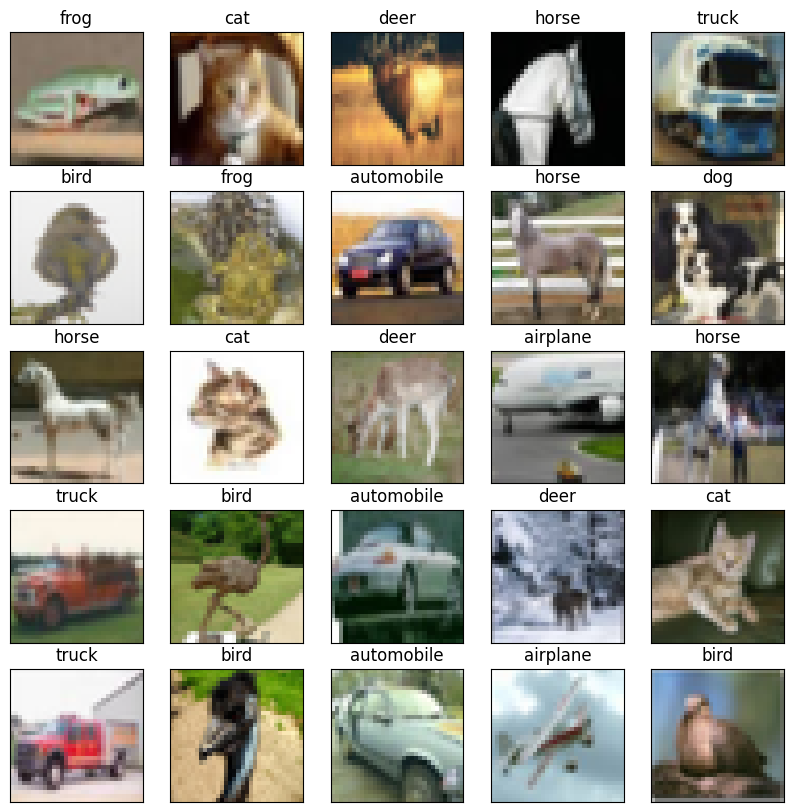

In [6]:
# Get the first batch. 
# (This may take a moment as it reads and caches the Dataset)
sample_imgs, sample_labels = train_data.as_numpy_iterator().next()

# The canvas size is first initialized by setting the parameter figsize in function plt.figure()
plt.figure(figsize=(10,10)) 
for i in range(25):
    plt.subplot(5,5,i+1)  # draw five rows and five columns in canvas
    plt.imshow(sample_imgs[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[np.argmax(sample_labels[i])])
plt.show()

# Implementing a neural network

We now implement a straightforward neural network. We have an input layer, a `Flatten` layer that converts the 32×32×3 image into a set of 3027 values, and two `Dense` layers to do the classification.

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(INPUT_SHAPE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(class_num, activation='softmax')
])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,258 (3.01 MB)

 Trainable params: 789,258 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

The summary shows the structure of the network and how many parameters it has. In this case, just over three-quarters of a million.

We `compile` the model with some parameters to control how training progresses, then we `fit` the model to the training data. The validation data isn't used to train the network. Instead, after each epoch of training, we evalaute the model on the validation data to see how well it performs on other data. This helps when it comes to overfitting, as we'll see later.

In [81]:
model.compile(
    'SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
history = model.fit(train_data,
    validation_data=validation_data,
    epochs=10,
         )

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2116 - loss: 2.2006 - val_accuracy: 0.2864 - val_loss: 2.0285
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3130 - loss: 1.9896 - val_accuracy: 0.2904 - val_loss: 1.9681
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3380 - loss: 1.9089 - val_accuracy: 0.3168 - val_loss: 1.9149
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3573 - loss: 1.8654 - val_accuracy: 0.3290 - val_loss: 1.8943
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3627 - loss: 1.8417 - val_accuracy: 0.3578 - val_loss: 1.8566
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3698 - loss: 1.8200 - val_accuracy: 0.3402 - val_loss: 1.8585
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3731 - loss: 1.8080 - val_accuracy: 0.3624 - val_loss: 1.8289
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3815 - loss: 1.7916 - val_accuracy: 0.

We can see how the accuracy of the model changes over training. We can also see that the accuracy when using the validation accuracy is similar to the training data.

<Figure size 640x480 with 0 Axes>

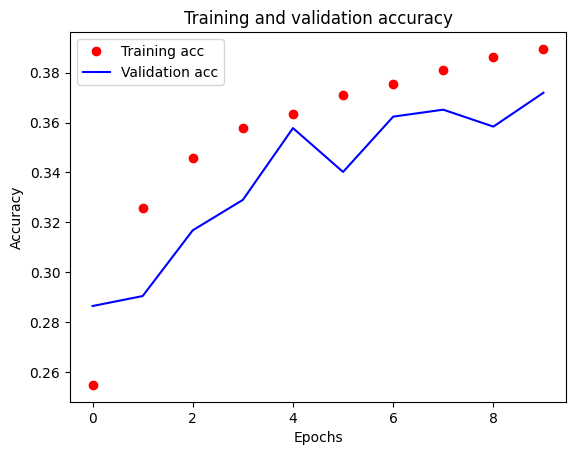

<Figure size 640x480 with 0 Axes>

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()  # Automatic detection of elements to be shown in the legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

### Making predictions on test data

We can now use the model to make predictions on the test data.

In [84]:
test_predictions = model.predict(test_data)
test_predictions.shape

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(10000, 10)

This gives us 10,000 predictions across ten classes. If we look at one of the predictions, we can see the probabilities of the different classes. 

In [85]:
test_predictions[1]

array([0.06330556, 0.27714074, 0.0572618 , 0.14016785, 0.06736848,
       0.06740825, 0.10462798, 0.080957  , 0.04962496, 0.09213744],
      dtype=float32)

The predicted label is the index of the highest-valued output for each prediction.

In [86]:
predict_labels = np.argmax(test_predictions, axis=1)

Now we view some images and give the predicted and actual labels for each. 

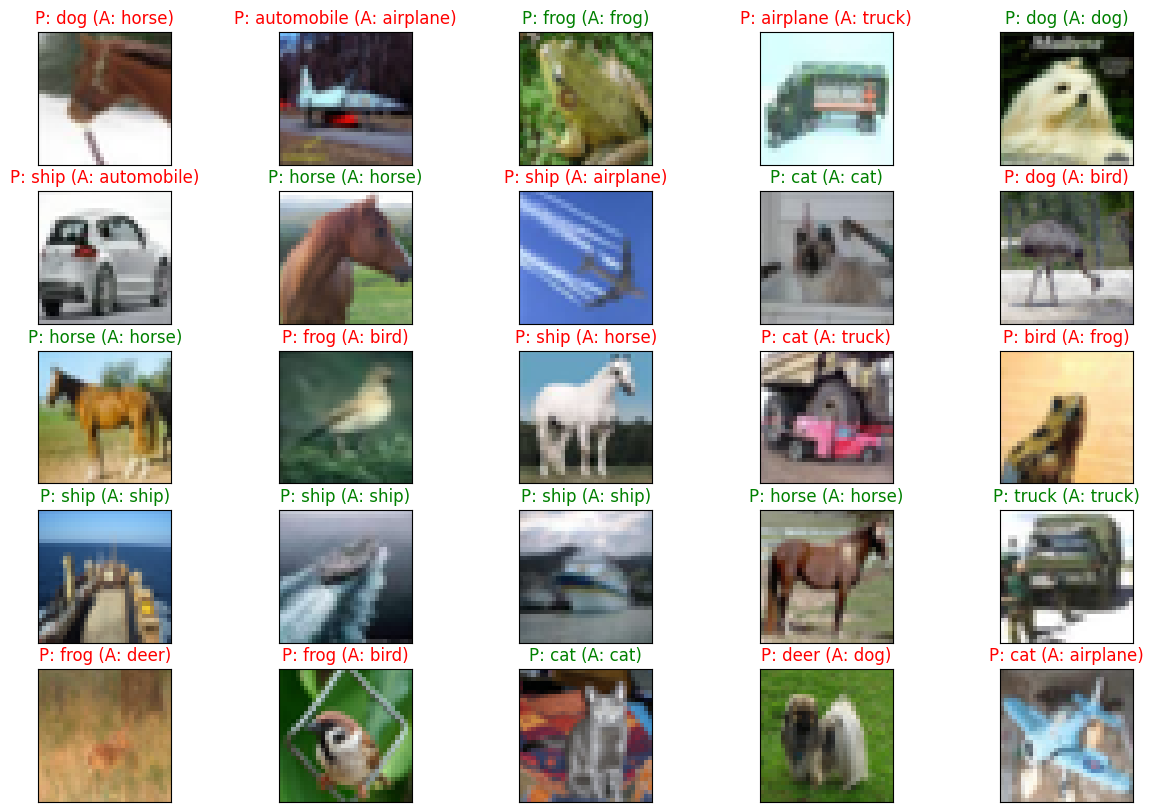

In [97]:
# View the true and predicted labels of sample images
plt.figure(figsize=(15,10))
test_imgs, test_labels = test_data.as_numpy_iterator().next()

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_imgs[i], cmap=plt.cm.binary)
    p_class = predict_labels[i]
    a_class = np.argmax(test_labels[i])
    plt.title(f"P: {class_names[p_class]} (A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()


Finally, we can evaluate the overall accuracy of the model on test data.

In [88]:
model_results = model.evaluate(test_data, return_dict=True)
model_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3813 - loss: 1.7717


{'accuracy': 0.3790999948978424, 'loss': 1.7815040349960327}

Your results will vary, as your neural network was given its own random weights at the start. But you should see an accuracy of around 35–40%.

# Why use CNN?

The neural network above works, but not very well. Just under 40% accuracy, from a range on only ten classes, isn't great.

One reason for this is that network throws away all the spatial information in that first `Flatten` layer. Subsequent layers no longer know about which pixels are nearby to other pixels in the original image. A better approach would be to have a neural network that looks at just small regions of the image and feeds that to the next layers. 

That is a convolutional neural network.

## Convolution layer 

The idea of the convolution layer is to create a filter (also called kernel). The filter is used to scan across the image and create a representation of the image corresponding to the filter. In this way, we can think of the filter as a specific feature extraction mechanism for the image. For instance, a filter may detect a block of colour, or a horizontal edge, or a curve. 

A single convoution layer may contain many filters (32 filters in the example below). That means the layer can detect 32 features in the image. The network learns which features are important during training. 


![title](./pic/Example-filters.png)
 
If we use 32 different filters in the convolution layer, then we create 32 different representations, called **feature maps**, of the input image. These different feature maps in combination can help us identify the input image correctly.

How a filter operates is illustrated below. Simply speaking, we overlay a filter, which is a small matrix of weights, on top of the input matrix, e.g. starting from the top-left corner and then sliding from left to right and from top to bottom. 

![title](./pic/example-convolution.png)

The **filter** shown in the example is of size *3×3*. It is applied on a *5×5* input matrix (you can consider it as the matrix of pixels for an image). When the filter moves through the image it does its computation in each position, then moves to cover another *3×3* part of the input. The right-hand side matrix shows the output of each step. 

*The values in the kernel are learnt during the training step.*

# Building a CNN model
Let's use a convolution layer for image recognition. 

We'll use a convolution layer that has 32 filters. We then `Flatten` those neurons into a set of 33,000 neurons, and use a couple of `Dense` layers to use those features and create the image classification.

![title](pic/cnn-diagram-simple.png)

In [102]:
model2 = Sequential([
    Input(INPUT_SHAPE),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.5),
    Flatten(),
    Dense(128),
    Dense(class_num, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,196,618 (16.01 MB)

 Trainable params: 4,196,618 (16.01 MB)

 Non-trainable params: 0 (0.00 B)

Again, we compile and train the model.

In [103]:
model2.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [104]:
history = model2.fit(train_data,
    validation_data=validation_data,
    epochs=10,
         )

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3849 - loss: 2.1511 - val_accuracy: 0.5260 - val_loss: 1.3544
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5931 - loss: 1.1739 - val_accuracy: 0.5478 - val_loss: 1.2891
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6546 - loss: 1.0022 - val_accuracy: 0.5624 - val_loss: 1.3000
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6991 - loss: 0.8806 - val_accuracy: 0.5724 - val_loss: 1.2939
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7413 - loss: 0.7593 - val_accuracy: 0.5736 - val_loss: 1.3517
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7708 - loss: 0.6675 - val_accuracy: 0.5686 - val_loss: 1.4174
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7962 - loss: 0.5938 - val_accuracy: 0.5790 - val_loss: 1.4452
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8323 - loss: 0.4832 - val_accuracy: 0.

There's good news and bad news. 

The good news is that the accuracy is much better than when not using the convolution layer. The training accuracy will be about 85%, the validation accuracy about 55%.

The bad news is that difference between the performance on the training and validation data. It's clearer if we plot the training history.

<Figure size 640x480 with 0 Axes>

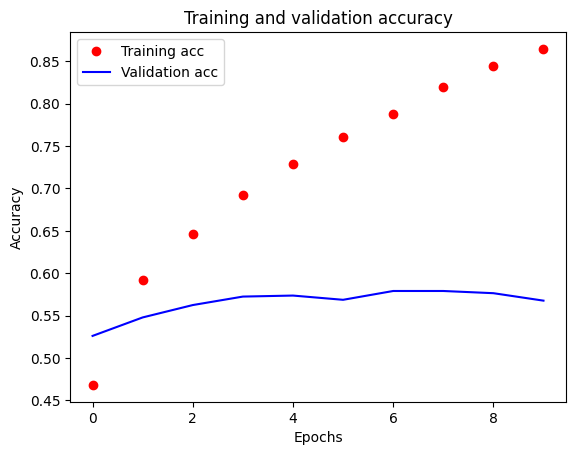

<Figure size 640x480 with 0 Axes>

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()  # Automatic detection of elements to be shown in the legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

This shows the model is _overfitting_: it's getting very good at classifying the training data, but does much less well on data it's not been trained on. (The validation data is used to check how well the model works, not to improve the model's performance.)

## Addressing overfitting

We can address overfitting by throwing away some of the information _inside_ the model during training. We do this in two ways: pooling and dropout.

Pooling uses the observation that pieces of the image near each other are very similar, and will have very similar feature maps from a convolutional layer. In any given small region ("pool") of a feature map, we can take just one pixel to go forward. Generally, we take the largest value in the pool.

Dropout just plain discards information during training. Networks can overfit if all the weights can be adjusted together. During training, a dropout layer will randomly turn off some of the connections with each training example. This allows the weights to change independently and therefore makes the network more robust.

By combining both pooling and dropout layers, we can afford to make the network deeper before overfitting occurs. We've done this in the model below, where we have three convolution layers. 

In [7]:
model3 = Sequential([
    Input((32, 32, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(class_num, activation='softmax')
])

model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [8]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,890 (370.66 KB)

 Trainable params: 94,890 (370.66 KB)

 Non-trainable params: 0 (0.00 B)

Note that the last feature map is only 4×4 across, but has 64 features to choose from.

We can now compile and train the model, this time for 30 epochs.

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2745 - loss: 1.9596 - val_accuracy: 0.4960 - val_loss: 1.3747
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4785 - loss: 1.4353 - val_accuracy: 0.5550 - val_loss: 1.2370
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5483 - loss: 1.2693 - val_accuracy: 0.6156 - val_loss: 1.0855
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5922 - loss: 1.1552 - val_accuracy: 0.6094 - val_loss: 1.0767
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6141 - loss: 1.0892 - val_accuracy: 0.6284 - val_loss: 1.0887
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6390 - loss: 1.0222 - val_accuracy: 0.6708 - val_loss: 0.9385
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6635 - loss: 0.9611 - val_accuracy: 0.6860 - val_loss: 0.8799
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6752 - loss: 0.9229 - val_accuracy: 0.

<Figure size 640x480 with 0 Axes>

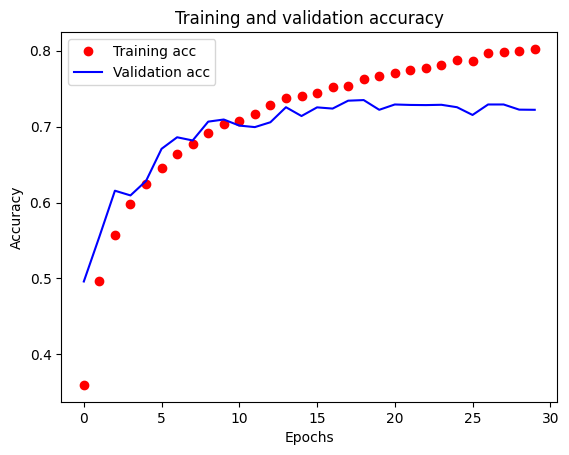

<Figure size 640x480 with 0 Axes>

In [9]:
history = model3.fit(train_data,
    validation_data=validation_data,
    epochs=30
         )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure();

This seems to have gone much better. The accuracy is better, and the accuracy of the validation dataset is very close to the training dataset.

How does it work on the test dataset?

In [10]:
model3_results = model3.evaluate(test_data, return_dict=True)
model3_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7351 - loss: 0.9017


{'accuracy': 0.7332000136375427, 'loss': 0.9049357771873474}

Your results will vary, but you'll probably see an accuracy in the 70–75% range.

We can show some images with their predicted and actual labels.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


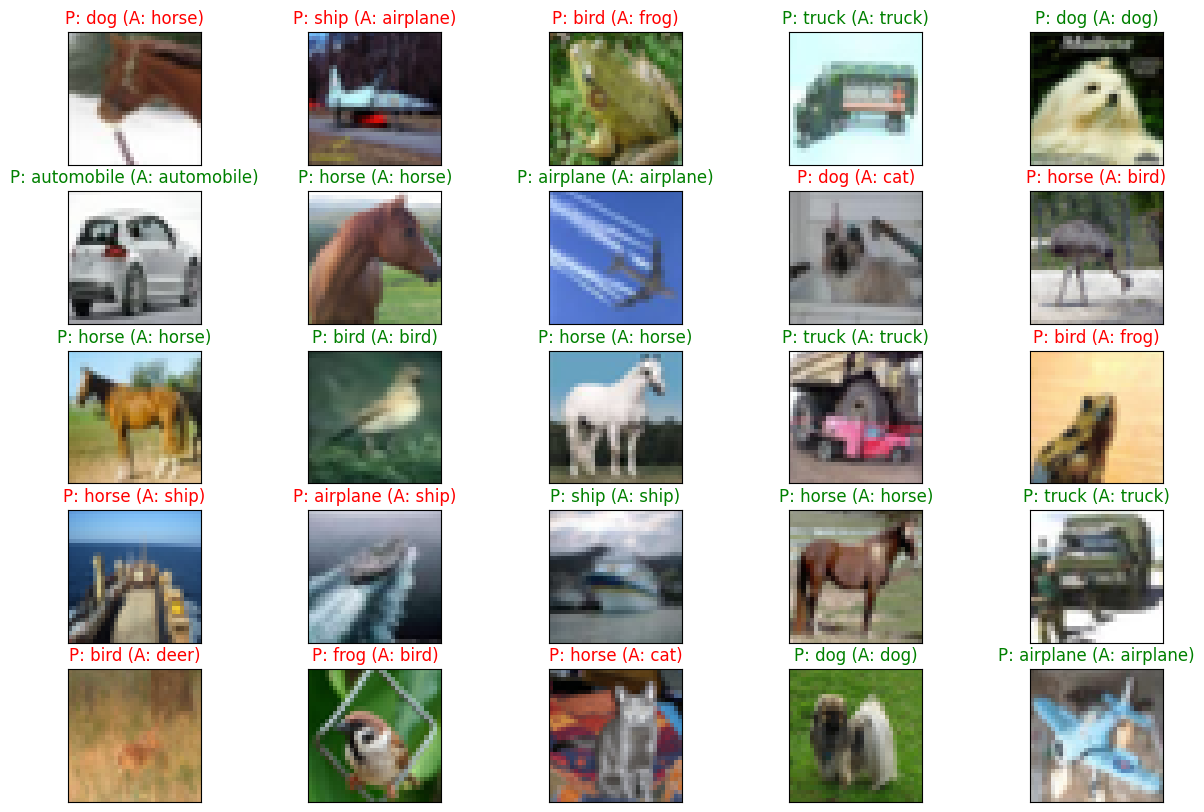

In [38]:
test_predictions = model3.predict(test_data)

predict_labels = np.argmax(test_predictions, axis=1)

# View the true and predicted labels of some sample images

plt.figure(figsize=(15,10))
test_imgs, test_labels = test_data.as_numpy_iterator().next()

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_imgs[i])
    p_class = predict_labels[i]
    a_class = np.argmax(test_labels[i])
    
    plt.title(f"P: {class_names[p_class]} (A: {class_names[a_class]})",
                                  color=("green" if p_class == a_class else "red"))
plt.show()

This shows the output of the model, but we can also peer inside it and look at the feature maps it generates. 

We do that by creating another "model" that reuses the same trained layers in `model3`. The input to this new model is the same as before, but the model's output is the output of the first convolutional layer.

First we need to check the locations of the convolutional layers in the model.

In [12]:
list(enumerate(model3.layers))

[(0, <Conv2D name=conv2d, built=True>),
 (1, <MaxPooling2D name=max_pooling2d, built=True>),
 (2, <Conv2D name=conv2d_1, built=True>),
 (3, <MaxPooling2D name=max_pooling2d_1, built=True>),
 (4, <Conv2D name=conv2d_2, built=True>),
 (5, <MaxPooling2D name=max_pooling2d_2, built=True>),
 (6, <Flatten name=flatten, built=True>),
 (7, <Dense name=dense, built=True>),
 (8, <Dropout name=dropout, built=True>),
 (9, <Dense name=dense_1, built=True>)]

We now create the model with the same input and first convolutional layer.

In [13]:
intermediate_layer_model = keras.Model(inputs=model3.inputs,
                                       outputs=model3.layers[0].output)
intermediate_layer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

We now look at the feature maps for a particular image. We'll use image 0 from the test batch.

In [41]:
test_image_number = 0

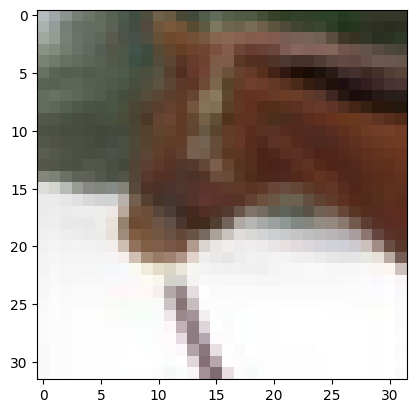

In [50]:
# ploting the original image
plt.figure()
plt.imshow(test_imgs[test_image_number]) 

Now we can show some sample outputs of the intermediate model: the feature maps of this image.

In [43]:
intermediate_output = intermediate_layer_model(test_imgs)

TensorShape([64, 32, 32, 32])

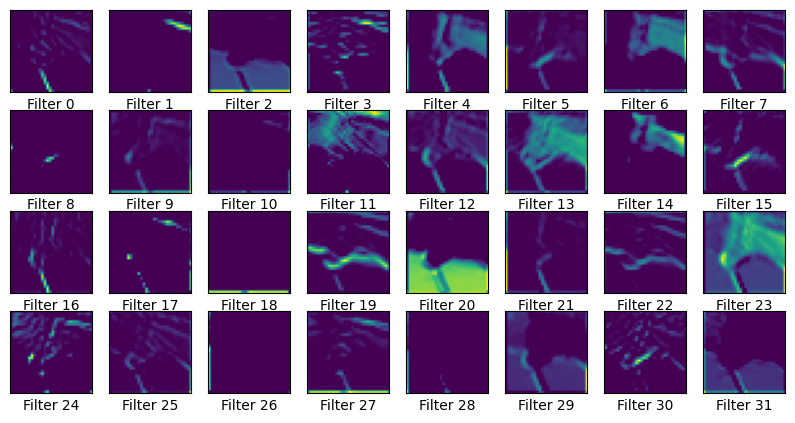

In [44]:
plt.figure(figsize=(10, 5))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[test_image_number,:,:,i]) 
    plt.xlabel(f'Filter {i}', fontsize=10)

I've no idea what features your model will find. But you'll probably see some feature maps that indicate foreground or background, and some that detect edges between them in different directions. 

These are the features that later stages in the model will work with.

Following the same process, we can look at the output of the second covolutional layer.

In [19]:
intermediate_layer_model2 = keras.Model(inputs=model3.inputs,
                                       outputs=model3.layers[2].output)
intermediate_layer_model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,144 (39.62 KB)

 Trainable params: 10,144 (39.62 KB)

 Non-trainable params: 0 (0.00 B)

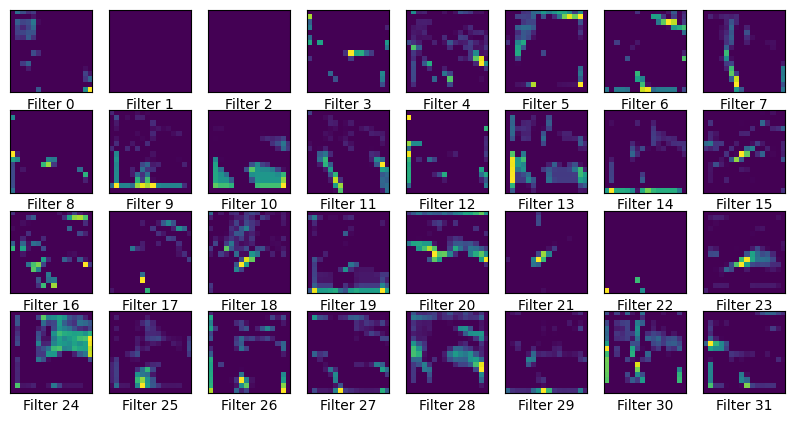

In [51]:
intermediate_output2 = intermediate_layer_model2(test_imgs)

plt.figure(figsize=(10, 5))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output2[test_image_number,:,:,i]) 
    plt.xlabel(f'Filter {i}', fontsize=10)

These features will be more abstract than the ones before, as they're combinations of some or many of the features from the first convolutional layer.

Finally, the third convolutional layer.

In [22]:
intermediate_layer_model3 = keras.Model(inputs=model3.inputs,
                                       outputs=model3.layers[4].output)
intermediate_layer_model3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,640 (111.88 KB)

 Trainable params: 28,640 (111.88 KB)

 Non-trainable params: 0 (0.00 B)

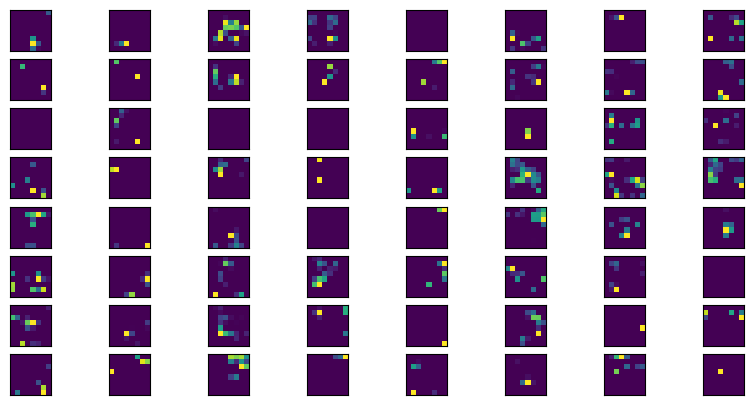

In [55]:
intermediate_output3 = intermediate_layer_model3(test_imgs)

# Plotting the 8 intermediate feature maps generated by the 8 filters in the first convolution layer

plt.figure(figsize=(10, 5))

for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output3[test_image_number,:,:,i]) 

These will bear very little direct connection to the input image, but should somehow encode important features that help the classification of the image.

In [56]:
test_image_number = 9

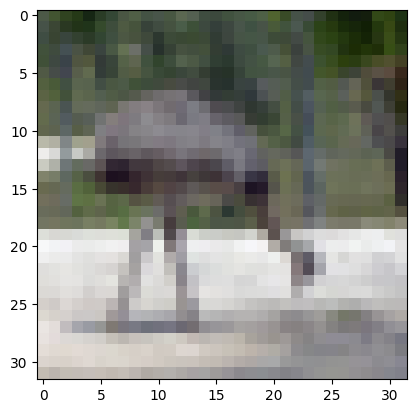

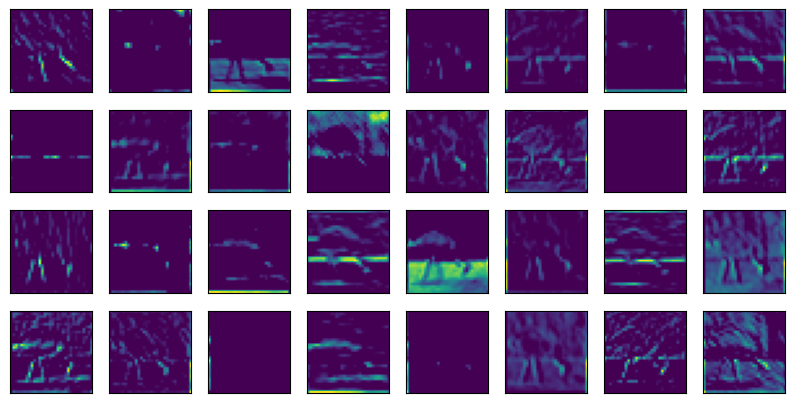

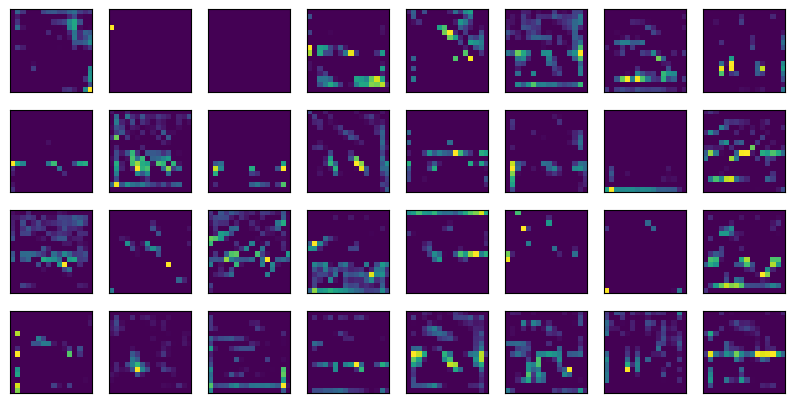

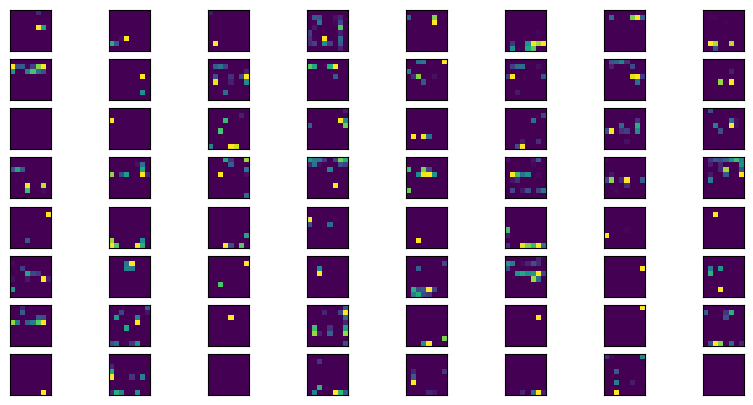

In [57]:
plt.imshow(test_imgs[test_image_number]) 

plt.figure(figsize=(10, 5))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output[test_image_number,:,:,i]) 
    # plt.xlabel(f'Filter {i}', fontsize=10)

plt.figure(figsize=(10, 5))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output2[test_image_number,:,:,i]) 
    # plt.xlabel(f'Filter {i}', fontsize=10)

plt.figure(figsize=(10, 5))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(intermediate_output3[test_image_number,:,:,i]) 
    # plt.xlabel(f'Filter {i}', fontsize=10)

# Conclusion

With these activities, you've explored some of the techniques of modern machine learning and artificial intelligence. Deep convolutional neural networks are a mainstay of deployed AI systems and are used for all sorts of image processing tasks. Variations on these ideas can be applied to other types of data, such as understanding speech and text. 

You've also looked at how convolutional networks work internally, with the creation of feature maps that encode important parts of the image, and how these feature maps are combined to give higher-level representations of an input.

You've also seen why these systems take a lot of time, computing power, and data to get good performance. The CIFAR dataset is only small, but required many rounds of training, on specific hardware, to get good results. 

CNNs are just one technique in machine learning, but the ideas you used here should give you a much better understanding of how these systems work. 